In [11]:
import pandas as pd
pd.options.display.max_colwidth = 1000
import numpy as np
import matplotlib.pyplot as plt
#import plotly
#import plotly.plotly as py
from plotly import tools, offline
#plotly.tools.set_credentials_file(username='mtodisco10', api_key='bCfUmq5FralbymKXY4uX')
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
#from IPython.display import display, HTML
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
%run progress_bar.ipynb
%run field_layout.ipynb

In [3]:
#Read in Data
game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
video_footage_control = pd.read_csv('video_footage-control.csv')
video_footage_injury = pd.read_csv('video_footage-injury.csv')
video_review = pd.read_csv('video_review.csv')

In [4]:
#Create a function to read in all of the Next Gen Stats data 
#Concatenate the individual files into one large file

def read_NGS_data(file_lst):
    for i, file in enumerate(file_lst):
        print('Reading in {}'.format(file))
        data = pd.read_csv(file)
        if i == 0:
            NGS_df = data
            del data
        else:
            NGS_df = pd.concat([NGS_df, data])
            del data
    return NGS_df

In [5]:
file_lst = ['NGS-2016-pre.csv','NGS-2016-reg-wk1-6.csv','NGS-2016-reg-wk7-12.csv','NGS-2016-reg-wk13-17.csv',\
            'NGS-2016-post.csv','NGS-2017-pre.csv','NGS-2017-reg-wk1-6.csv','NGS-2017-reg-wk7-12.csv',\
            'NGS-2017-reg-wk13-17.csv','NGS-2017-post.csv']

In [6]:
#Takes ~10 mins to read in all Next Gen Stats data
NGS_df = read_NGS_data(file_lst)

Reading in NGS-2016-pre.csv
Reading in NGS-2016-reg-wk1-6.csv
Reading in NGS-2016-reg-wk7-12.csv
Reading in NGS-2016-reg-wk13-17.csv
Reading in NGS-2016-post.csv
Reading in NGS-2017-pre.csv
Reading in NGS-2017-reg-wk1-6.csv
Reading in NGS-2017-reg-wk7-12.csv
Reading in NGS-2017-reg-wk13-17.csv
Reading in NGS-2017-post.csv


## Exploratory Data Analysis

In [294]:
print('There are concussion injuries on ' \
      + str(round(len(video_review) / float(len(play_info)) * 100, 2)) \
      + '% of ' + 'punt plays')

There are concussion injuries on 0.55% of punt plays


My initial reaction is that head injuries are already rare on punt plays (<1%).
However, given the severity of these injuries, any reduction to concussions can be beneficial for the NFL.
### How are players being injured?
Explore:
    - Primary player acitivities
    - Impact types (ex. Helmet-to-Helmet)
    - Friendly Fire
    - Partner activities

In [302]:
#Create bar graphs to show the counts for each topic

trace1 = go.Bar(
        x=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['Player_Activity_Derived'],
        y=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID']
    )
trace2 = go.Bar(
        x=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['Primary_Impact_Type'],
        y=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace3 = go.Bar(
        x=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['Friendly_Fire'],
        y=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace4 = go.Bar(
        x=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['Primary_Partner_Activity_Derived'],
        y=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID'],
    )

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('Player Activity Derived', 'Primary Impact Type',
                                                          'Friendly Fire', 'Primary Partner Activity Derived'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout'].update(showlegend=False)

iplot(fig, filename='injury-eda')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



#### Quick Conclusions
    - No primary player activity significantly stands out
    - Surprisingly, helmet-to-helmet and helmet-to-body are involved in the same amount of injuries
    - Friendly fire is only clear 16% of the time
    - No partner activity Stands Out

### Who's getting hurt?
Explore:
    - The side of the ball (coverage vs return)
    - The punt role of the players involved

In [345]:
#Categorize player punt roles into sides of the ball
return_roles = ['PDL1','PDL2','PDL3','PDL4','PDL5','PDL6','PDM','PDR1','PDR2','PDR3','PDR4','PDR5','PDR6'
                ,'PFB','PLL','PLL1','PLL2','PLL3','PLM','PLM1','PLR','PLR1','PLR2','PLR3','PR','VL','VLi'
                ,'VLo','VR','VRi','VRo']

coverage_roles = ['GL','GLi','GLo','GR','GRi','GRo','P','PC','PLG','PLS','PLT','PLW','PPL','PPLi','PPLo'
                 ,'PPR','PPRi','PPRo','PRG','PRT','PRW']

gunner_blockers = ['VL','VLi','VLo','VR','VRi','VRo']

In [346]:
#Merge the player role data with the injury review data on the primary player
inj_players = video_review.merge(play_player_role, how='inner', on=['Season_Year', 'GameKey', 'PlayID', 'GSISID'])
inj_players.rename(columns={'Role':'inj_role'}, inplace=True)

#Create a column to determine side of the ball
inj_players['inj_side_of_ball'] = np.where(inj_players.inj_role.isin(return_roles), 'return',
                                          np.where(inj_players.inj_role.isin(coverage_roles), 'coverage', ''))

In [347]:
#Merge the player role data with the injury review data on the partner player
partner_players = video_review[['Season_Year', 'GameKey', 'PlayID', 'Primary_Partner_GSISID']]
partner_players['Primary_Partner_GSISID'] = partner_players.loc[:,'Primary_Partner_GSISID'] \
                                                .replace('Unclear','0').fillna(0).astype(int)
partner_players = partner_players.merge(play_player_role, how='left', \
                                        left_on=['Season_Year', 'GameKey', 'PlayID', 'Primary_Partner_GSISID'],\
                                       right_on =['Season_Year', 'GameKey', 'PlayID', 'GSISID'])
partner_players = partner_players.drop('GSISID', axis=1)
partner_players.rename(columns={'Role':'partner_role'}, inplace=True)

#Create a column to determine side of the ball
partner_players['partner_side_of_ball'] = np.where(partner_players.partner_role.isin(return_roles), 'return',
                                          np.where(partner_players.partner_role.isin(coverage_roles), 'coverage', ''))

#Concatenate the primary and partner dataframes
inj_partner_df = pd.concat([inj_players,partner_players[['partner_role','partner_side_of_ball']]], axis = 1)

In [348]:
#Create bar graphs to visualize the injuries on each side of the ball for primary and partner
trace1 = go.Bar(
        x=inj_partner_df.groupby(['inj_side_of_ball'], as_index=False)['PlayID'].count()['inj_side_of_ball'],
        y=inj_partner_df.groupby(['inj_side_of_ball'], as_index=False)['PlayID'].count()['PlayID']
    )

trace2 = go.Bar(
        x=inj_partner_df.groupby(['partner_side_of_ball'], as_index=False)['PlayID'].count()['partner_side_of_ball'],
        y=inj_partner_df.groupby(['partner_side_of_ball'], as_index=False)['PlayID'].count()['PlayID']
    )

fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Injured Side of Ball', 'Partner Side of Ball'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(showlegend=False)

iplot(fig, filename='side-of-ball')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [349]:
#View the count of injuries by primary injured role
inj_partner_df.groupby('inj_role')['GSISID'].count().sort_values(ascending = False)

inj_role
PR      5
GL      4
PLG     4
PRG     4
PLW     4
PLT     2
PRW     2
PLS     2
PRT     2
PPR     1
PLL     1
PFB     1
PDR1    1
PDL2    1
P       1
GR      1
VR      1
Name: GSISID, dtype: int64

In [350]:
#View the count of injuries by partner role
inj_partner_df.groupby('partner_role')['GSISID'].count().sort_values(ascending = False)

partner_role
PR      8
GR      4
PDR1    3
PRT     2
PRG     2
PLT     2
PDR2    2
PDL1    2
VLo     1
PRW     1
PPR     1
PLW     1
PLS     1
PLL1    1
PLG     1
PDR3    1
Name: GSISID, dtype: int64

In [351]:
#Pivot the injury df to see count of injuries by primary and partner combination
pd.pivot_table(inj_partner_df, index=['inj_role'], columns=['partner_role'],
              values='GSISID', aggfunc='count', margins=True).fillna('-')

partner_role,GR,PDL1,PDR1,PDR2,PDR3,PLG,PLL1,PLS,PLT,PLW,PPR,PR,PRG,PRT,PRW,VLo,All
inj_role,,,,,,,,,,,,,,,,,
GL,1,-,-,-,1,-,1,-,-,-,-,1,-,-,-,-,4.0
GR,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,-,1.0
P,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,1.0
PDL2,-,-,-,-,-,-,-,1,-,-,-,-,-,-,-,-,1.0
PDR1,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1.0
PFB,-,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,1.0
PLG,-,-,1,-,-,-,-,-,-,1,-,-,-,-,1,-,3.0
PLL,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
PLS,-,1,-,-,-,-,-,-,-,-,-,1,-,-,-,-,2.0


#### Quick Conclusions
    - The primary player injured is on the coverage team 73% of the time
    - There is less of a gap between the side of the ball for partner players
        - 4 instances with no partner player
    - Looking at specific roles:
        - PR is involved in 13 total injuries - 8 of which are as a partner
        - The top coverage positions as primary injuries are PRG, PLW, PLG, GL
        - There is only 1 combination with more than 1 injury - PRG & PR

### On what types of plays are players getting hurt?

Explore:
    - What are the outcomes of punt plays?
    - What are the frequencies of each outcome?
    - What are the proportions of injuries for each outcome?

In [408]:
#Create a column in the play_info dataframe to determine the general outcome of play
play_info['outcome'] =  np.where(play_info['PlayDescription'].str.contains('aborted|Fumbled snap|FUMBLES, and recovers', flags=re.IGNORECASE, regex=True), 'aborted',
                        np.where(play_info['PlayDescription'].str.contains('fake|pass|right end|left end|up the middle|Direct snap|right guard', flags=re.IGNORECASE, regex=True), 'fake',
                        np.where(play_info['PlayDescription'].str.contains('muffs', flags=re.IGNORECASE, regex=True), 'muff',         
                        np.where(play_info['PlayDescription'].str.contains('fair catch by', flags=re.IGNORECASE, regex=True), 'fair_catch',
                        np.where(play_info['PlayDescription'].str.contains('touchback', flags=re.IGNORECASE, regex=True), 'touchback',
                        np.where(play_info['PlayDescription'].str.contains('blocked|deflected', flags=re.IGNORECASE, regex=True), 'blocked',
                        np.where(play_info['PlayDescription'].str.contains('out of bounds.', flags=re.IGNORECASE, regex=False), 'oob',
                        np.where(play_info['PlayDescription'].str.contains('downed', flags=re.IGNORECASE, regex=True), 'downed', 
                        np.where(play_info['PlayDescription'].str.contains('safety', flags=re.IGNORECASE, regex=True), 'safety',
                        np.where(play_info['PlayDescription'].str.contains('[0-9]+ for [-+]?[0-9]+ yards?|for no gain|touchdown|(to [A-Z]+ [0-9]+ for [-+]?[0-9]+ yards?)|(to [0-9]+ for [-+]?[0-9]+ yards?)', flags=re.IGNORECASE, regex=True), 'return',         
                        np.where(play_info['PlayDescription'].str.contains('- no play|delay of game|false start, declined|penalty enforced', flags=re.IGNORECASE, regex=True), 'no_play', ' ')))))))))))

#Merge the play info df with the injury df
pi = play_info.merge(video_review[['Season_Year', 'GameKey', 'PlayID','GSISID']], how='left', on =['Season_Year', 'GameKey', 'PlayID'])
pi['injury'] = np.where(pi.GSISID.notnull(), 1, 0).astype(int)
pi.drop('GSISID', axis = 1, inplace=True)
pi_inj_grouped = pi.groupby(['outcome'], as_index=False)['injury'] \
    .agg({'total_plays':'count','injuries':sum}) \
    .sort_values('total_plays', ascending = False) \
    .reset_index(drop=True)

pi_inj_grouped['injury_rate'] = round(pi_inj_grouped['injuries'] / pi_inj_grouped['total_plays'] * 100, 1).astype(str) + '%'
pi_inj_grouped

,outcome,total_plays,injuries,injury_rate
0,return,2741,29,1.1%
1,fair_catch,1659,2,0.1%
2,downed,796,3,0.4%
3,oob,639,0,0.0%
4,touchback,407,0,0.0%
5,muff,203,2,1.0%
6,no_play,139,0,0.0%
7,fake,45,1,2.2%
8,blocked,39,0,0.0%
9,aborted,9,0,0.0%


#### Quick Conclusions: 
    - Returns are the most frequent outcome (41%)
    - Over 1% of punt plays with a return have an injury
    - This is 10x higher than when a fair catch is called
    - The next 3 most frequent outcomes have lower than average injury rates
        - downed 0.4%
        - out of bounds 0%
        - touchback 0%

Since the majority of injuries are occuring when there is a return, I'll look to find the differences between returns and other outcomes, starting with the time the distance between the returner and the coverage team.

### Returner and Coverage Team Metrics During Punt
Explore:
    - Distribution of punt hang times
        - will need a general sense of how long the ball is in the air
    - For each second from the time the ball is punted to the time it is received:
        - calculate distance from each coverage man to the returner
        - calculate the speed (mph) for each player

##### Punt Hang Times

In [409]:
#Create a function to calculate the time in secs from punt to land
def get_hang_time(ngs_df, start_event='punt', *stop_events):
    punt_event = ngs_df.loc[ngs_df.Event==start_event] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    punt_event.rename(columns = {'Time':'punt_time'}, inplace=True)
    punt_event['punt_time'] = pd.to_datetime(punt_event['punt_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    receiving_event = ngs_df.loc[ngs_df.Event.isin(stop_events)] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    receiving_event.rename(columns = {'Time':'receiving_time'}, inplace=True)
    receiving_event['receiving_time'] = pd.to_datetime(receiving_event['receiving_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    punt_df = punt_event.merge(receiving_event, how='inner', on = ['Season_Year','GameKey','PlayID']) \
                .reset_index(drop=True)
    
    punt_df['hang_time'] = (punt_df['receiving_time'] - punt_df['punt_time']).dt.total_seconds()
    
    return punt_df

punt_df = get_hang_time(NGS_df, 'punt', 'punt_received', 'fair_catch')

#Visualize the hang times with a histogram
data = [go.Histogram(x=punt_df.hang_time)]

layout = go.Layout(
    title='Hang Time Histogram',
    xaxis=dict(
        title='Seconds'
    ),
    yaxis=dict(
        title='Count'
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic histogram')

In [410]:
#Print a few summary statistics
print('The mean hang time is ' + str(round(punt_df['hang_time'].mean(), 1)))
print('The median hang time is ' + str(round(punt_df['hang_time'].median(), 1)))
print(str(round(len(punt_df.loc[punt_df.hang_time < 6]) / len(punt_df) * 100, 1))\
      + '% of hang times are less than 5 1/2 seconds')

The mean hang time is 4.5
The median hang time is 4.5
98.6% of hang times are less than 5 1/2 seconds


#### Player Space and Speed

In [365]:
#Create a function to calculate the space between the returner and the closest coverage player for every second between the punt and the catch
def coverage_returner_space(play_df, ngs_df):
    cov_ret_lst = []
    for i in log_progress(range(0, len(play_df)), every=25):
        season_key = play_df['Season_Year'][i]
        game_key = play_df['GameKey'][i]
        play_id = play_df['PlayID'][i]
        outcome = play_df['outcome'][i]
        injury = play_df['injury'][i]
        if game_key in ngs_df.GameKey and play_id in ngs_df.PlayID:
            filtered_play = ngs_df.loc[(ngs_df.GameKey == game_key) \
                                       & (ngs_df.PlayID == play_id)].sort_values('Time').reset_index(drop=True)
            filtered_play = filtered_play.merge(play_player_role, \
                                                how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
            if len(filtered_play) > 0:
                filtered_play['Time'] = pd.to_datetime(filtered_play['Time'], \
                                                       format='%Y-%m-%d %H:%M:%S.%f')
                punt_event_time = filtered_play.loc[filtered_play.Event == 'punt'].Time.min()
                receiving_event_time = filtered_play.loc[(filtered_play.Event == 'punt_received') | \
                                                         (filtered_play.Event == 'fair_catch')].Time.min()
                gunner_blocker_count = len(filtered_play.loc[filtered_play['Role'].isin(gunner_blockers)]['Role'].unique())
                filtered_play = filtered_play.loc[(filtered_play.Time >= punt_event_time) & \
                                                  (filtered_play.Time <= receiving_event_time)]
                coverage_df = filtered_play.loc[filtered_play['Role'].isin(coverage_roles)].sort_values('Time')
                coverage_df.rename(columns={'x':'cov_x', 
                                          'y': 'cov_y',
                                          'GSISID': 'cov_GSISID',
                                          'dis': 'cov_dis',
                                          'o': 'cov_o',
                                          'dir': 'cov_dir',
                                          'Role': 'cov_Role'
                                         }, inplace=True)
                
                returner_df = filtered_play.loc[filtered_play['Role'] == 'PR'].sort_values('Time')
                returner_df.rename(columns={'x':'ret_x', 
                                          'y': 'ret_y',
                                          'GSISID': 'ret_GSISID',
                                          'dis': 'ret_dis',
                                          'o': 'ret_o',
                                          'dir': 'ret_dir',
                                          'Role': 'ret_Role'
                                         }, inplace=True)
                returner_df = returner_df.drop('Event', axis = 1)
                
                cov_ret_df = coverage_df.merge(returner_df, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])
                cov_ret_df['dis_from_ret'] = ((cov_ret_df['cov_x'] -  cov_ret_df['ret_x']) ** 2 \
                                           + (cov_ret_df['cov_y'] -  cov_ret_df['ret_y']) ** 2).apply(np.sqrt)
                cov_ret_df['time_since_punt'] = cov_ret_df['Time'] - punt_event_time
                times_to_capture = [punt_event_time + pd.Timedelta(seconds=i) for i in range(0, 7)]
                cov_ret_df = cov_ret_df.loc[cov_ret_df['Time'].isin(times_to_capture)]
                cov_ret_df['gunner_blockers'] = gunner_blocker_count
                cov_ret_df['outcome'] = outcome
                cov_ret_df['injury'] = injury
                cov_ret_df['cov_speed'] = convert_to_mph(cov_ret_df.cov_dis, 20.455)
                cov_ret_df['ret_speed'] = convert_to_mph(cov_ret_df.ret_dis, 20.455)
                if len(cov_ret_df) > 0:
                    cov_ret_lst.append(cov_ret_df)
                    
    cov_ret_df = pd.concat(cov_ret_lst).reset_index(drop=True)          
    return cov_ret_df

def convert_to_mph(dis_vector, converter):
    mph_vector = dis_vector * converter
    return mph_vector

cov_ret_df = coverage_returner_space(pi, NGS_df)

#### Injury Play Animation and Distance Calculation
- For an added visualization, below is animation of an example play
- It tracks the paths of an injured punt returner and the cover man involved in the tackle
- The animation also shows the distance between the two players during the play

In [374]:
from IPython.display import display, HTML

#Selecting an exmple injury play for returner and coverman
ex_play = NGS_df.loc[(NGS_df.Season_Year==2016) & (NGS_df.GameKey== 234) \
                     & (NGS_df.PlayID== 3278) & (NGS_df.GSISID== 28620)
                    ].sort_values('Time')

ret_play = NGS_df.loc[(NGS_df.Season_Year==2016) & (NGS_df.GameKey== 234) \
                     & (NGS_df.PlayID== 3278) & (NGS_df.GSISID== 27860)].sort_values('Time')

#Removing time prior to the ball being snapped
ball_snap_time = ex_play.loc[ex_play.Event == 'ball_snap'].Time.min()
ex_play = ex_play.loc[ex_play.Time >= ball_snap_time].reset_index(drop=True)
ret_play = ret_play.loc[ret_play.Time >= ball_snap_time].reset_index(drop=True)

#Filling NA's in the event column with the prior event
ex_play['Event'] = ex_play['Event'].fillna(method='ffill')

#Data for Animation
x = np.array(ex_play.x)
y = np.array(ex_play.y)
xx = np.array(ex_play.x)
yy = np.array(ex_play.y)

x1 = np.array(ret_play.x)
y1 = np.array(ret_play.y)
xx1 = np.array(ret_play.x)
yy1 = np.array(ret_play.y)

N = len(x)

data=[dict(x=x, y=y, 
            name='Distance',
            mode='lines',
            textposition='bottom center',
            line=dict(width=2, color=None)
          ),
      dict(x=x, y=y, 
            name='Injured Player',
            mode='markers',
            marker=dict(color=None, size=15)
          ),
      dict(x=x1, y=y1, 
           name = 'Partner Player',
           mode='markers',
           marker=dict(color='orange', size=15)
         )
    ]

layout = load_field()
layout['hovermode'] = 'closest'
layout['updatemenus'] = [{'type': 'buttons',
                           'buttons': [{'label': 'Play',
                                        'method': 'animate',
                                        'args': [None]}]}]

frames=[dict(data=[dict(x=[x1[k]], 
                        y=[y1[k]], 
                        mode='markers', 
                        marker=dict(color='#013369', size=15),
                        name='Partner Player'
                        ),
                   dict(x=[x[k]], 
                        y=[y[k]], 
                        mode='markers', 
                        marker=dict(color='orange', size=15),
                        name='Injured Player'
                        ), 
                   dict(x=[xx[k], xx1[k], None, xx[k], xx1[k]], 
                        y=[yy[k], yy1[k], None, yy[k], yy1[k]], 
                        mode='lines', 
                        text='Distance: {}'.format(round(np.sqrt((xx1[k] - xx[k])**2 + (yy1[k] - yy[k])**2),0)),
                        textposition='bottom center',
                        line=dict(color='#2c3539', width=2),
                        name='Distance'
                       )
                  ], layout=dict(title=ex_play.Event[k],
                                 annotations=[
                                     dict(x=100,
                                          y=5,
                                          showarrow=False,
                                          font=dict(
                                              family='Courier New, monospace',
                                              size=14,
                                              color='#ffffff'),
                                          align='center',
                                          bordercolor='#c7c7c7',
                                          borderwidth=2,
                                          borderpad=4,
                                          bgcolor='#2c3539',
                                          opacity=0.8,
                                          text='{} Yds'.format(round(np.sqrt((xx1[k] - xx[k])**2 + (yy1[k] - yy[k])**2),0)),
                                          )
                                 ]
                                )
            ) for k in range(0, N, 5)]
          
figure1=dict(data=data, layout=layout, frames=frames)
iplot(figure1)

#### Analyzing coverage and returner data frame

Explore:
    - How far is each coverage position from the returner during the punt?
    - When does the coverage team close the most distance?
    - Which coverage positions have the greatest impact on returns?
        - Focusing on returns vs fair catches

In [405]:
#Create a line graph to show the average distance from the returner for each coverage position at each second of the punt

by_time_pos = cov_ret_df.groupby(['time_since_punt', 'cov_Role'], as_index=False)['dis_from_ret'].mean()

trace_lst = []

for role in by_time_pos.cov_Role.unique():
    if role not in ['Go', 'PC', 'PPLi', 'PPLo']:
        trace = go.Scatter(
            x = by_time_pos.loc[by_time_pos.cov_Role == role].time_since_punt.dt.total_seconds(),
            y = by_time_pos.loc[by_time_pos.cov_Role == role].dis_from_ret,
            mode = 'lines',
            name = role
        )

        trace_lst.append(trace)

data = trace_lst

layout = dict(title = 'Distance From Returner by Coverage Position ',
              xaxis = dict(title = 'Seconds from Punt'),
              yaxis = dict(title = 'Avg Distance (Yds)', 
                           range = [0,60]),
              hovermode = 'closest')

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')

In [406]:
#Create a grouped bar graph to show the avg distance from the returner for each coverage position by return vs fair catch
#Group inside and outside gunners into left and right
cov_ret_df = cov_ret_df.replace('GLi', 'GL').replace('GLo', 'GL').replace('GRi', 'GR').replace('GRo', 'GR')

pos_grouped_df = cov_ret_df.groupby(['cov_Role', 'outcome'], as_index=False)['dis_from_ret'].agg({'mean_dist':np.mean,
                                                                                                  'count': 'count'})
                                                                                                  
pos_grouped_df = pos_grouped_df.loc[(pos_grouped_df.cov_Role != 'PPLi') & \
                                    (pos_grouped_df.cov_Role != 'PPLo') & \
                                    (pos_grouped_df.cov_Role != 'PC') & \
                                    (pos_grouped_df.cov_Role != 'Go')]

trace1 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['mean_dist'],
        name='fair catch'
    )

trace2 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['mean_dist'],
        name='return'
    )

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Position'),
    yaxis= dict(title='Avg Distance From Returner (Yds)')
)

fig=go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [407]:
#From the graphs above, it's clear that on average the gunners are closest to the returner
#The below code shows at each second, how often a gunner is the closest to the returner

min_dist_from_ret = cov_ret_df.groupby(['Season_Year', 'GameKey','PlayID','time_since_punt'],
                                       as_index = False)['dis_from_ret'].min()

closest_df = cov_ret_df.merge(min_dist_from_ret.drop('time_since_punt', axis = 1),
                              how = 'inner',
                              on=['Season_Year', 'GameKey', 'PlayID', 'dis_from_ret'])


closest_df = closest_df.groupby(['time_since_punt','cov_Role'],
                   as_index=False)['dis_from_ret'].agg({'# of times closest': 'count',
                                                        'avg distance':np.mean})\
        .sort_values(['time_since_punt', '# of times closest'], ascending=[True, False])\
        .reset_index(drop=True)

gunner_times_closest = []
other_times_closest = []

for sec in closest_df.time_since_punt.unique():
    sec_df = closest_df.loc[closest_df.time_since_punt == sec]
    gunner_times_closest.append(sec_df.loc[sec_df.cov_Role.isin(['GR', 'GL'])]['# of times closest'].sum())
    other_times_closest.append(sec_df.loc[-sec_df.cov_Role.isin(['GR', 'GL'])]['# of times closest'].sum())
    
final_closest_df = pd.DataFrame({'time_since_punt': closest_df.time_since_punt.unique(),
            'gunner_closest': gunner_times_closest,
              'other_closest': other_times_closest
             }, columns = ['time_since_punt', 'gunner_closest', 'other_closest'])

final_closest_df['gunner_closest_perc'] = (final_closest_df['gunner_closest'] / \
                                          (final_closest_df['gunner_closest'] + final_closest_df['other_closest']) \
                                            * 100).round(1).astype(str) + '%'

final_closest_df[['time_since_punt','gunner_closest_perc']].set_index('time_since_punt')

,gunner_closest_perc
time_since_punt,
00:00:00,89.7%
00:00:01,89.0%
00:00:02,87.6%
00:00:03,85.7%
00:00:04,82.7%
00:00:05,74.7%
00:00:06,67.7%


#### Quick Conclusions: 
    - It's clear gunners are the most important players on the coverage team
        - They close the distance to the returner the quickest
        - On average, they are typically **** yards closer than any other position
        - The gunners are the closest cover men to the returner 70-90% of the time

In [379]:
#Since it is very rare that the return team has 0, 1, or 5 gunner blockers, we filter those plays out
print(round(cov_ret_df.gunner_blockers.value_counts(normalize=True), 2))
cov_ret_df = cov_ret_df.loc[cov_ret_df.gunner_blockers.isin([2, 3, 4])]

2    0.47
3    0.31
4    0.22
Name: gunner_blockers, dtype: float64


In [380]:
#Visualize play counts by alignment with a pie graph
labels = cov_ret_df.groupby(['gunner_blockers'], \
                   as_index=False)['PlayID'].agg({"play_count": pd.Series.nunique})['gunner_blockers']

values = cov_ret_df.groupby(['gunner_blockers'], \
                   as_index=False)['PlayID'].agg({"play_count": pd.Series.nunique})['play_count']

trace = go.Pie(labels=labels, values=values)

iplot([trace], filename='alignment_pie')

In [378]:
#Create a table to show the return rates by the # of gunner blockers
cov_ret_count = cov_ret_df.groupby('gunner_blockers', \
                                     as_index=False)['PlayID'].agg({"play_count": pd.Series.nunique}) 

cov_ret_returns = cov_ret_df.loc[cov_ret_df.outcome == 'return'].groupby('gunner_blockers', \
                                     as_index=False)['PlayID'].agg({"return_count": pd.Series.nunique})

cov_ret_merged = cov_ret_count.merge(cov_ret_returns)

cov_ret_merged['return_rate'] = (cov_ret_merged['return_count'] / 
                                 cov_ret_merged['play_count'] * 100).round(1).astype(str) + '%'

#Create similar table but with injury rates
cov_ret_injury = cov_ret_df.loc[cov_ret_df.injury == 1].groupby('gunner_blockers', \
                                     as_index=False)['PlayID'].agg({"injury_count": pd.Series.nunique})

cov_ret_merged = cov_ret_merged.merge(cov_ret_injury)

cov_ret_merged['injury_rate'] = (cov_ret_merged['injury_count'] / 
                                 cov_ret_merged['play_count'] * 100).round(1).astype(str) + '%'

#Merge the two data frames and only show the rates for easier viewing
cov_ret_merged[['gunner_blockers', 'return_rate', 'injury_rate']]

,gunner_blockers,return_rate,injury_rate
0,2,49.5%,0.6%
1,3,75.8%,1.0%
2,4,80.0%,1.2%


#### Quick Conclusions: 
    - 2 gunner blockers have the lowest return rate
    - 2 gunner blockers have the lowest injury rate

### Show correct vs incorrect alignment

In [381]:
def visualize_alignment(next_gen_df, game_id_lst, role_df):
    alignment_df = next_gen_df.loc[(next_gen_df.Season_Year == game_id_lst[0]) & \
                        (next_gen_df.GameKey == game_id_lst[1]) & \
                        (next_gen_df.PlayID == game_id_lst[2]) & \
                        (next_gen_df.Event == game_id_lst[3])].sort_values('y').reset_index(drop=True)
    
    align_merged = alignment_df.merge(play_player_role, how='left', \
                                          on =['Season_Year', 'GameKey', 'PlayID', 'GSISID'])
    
    align_merged['side_of_ball'] = np.where(align_merged.Role.isin(return_roles), 'return',
                                          np.where(align_merged.Role.isin(coverage_roles), 'coverage', ''))
    
    trace1 = go.Scatter(
        x = align_merged.loc[align_merged.side_of_ball == 'return'].x,
        y = align_merged.loc[align_merged.side_of_ball == 'return'].y,
        mode = 'markers',
        marker = dict(color='#013369', size=10),
        name = 'Return'
    )

    trace2 = go.Scatter(
        x = align_merged.loc[align_merged.side_of_ball == 'coverage'].x,
        y = align_merged.loc[align_merged.side_of_ball == 'coverage'].y,
        mode = 'markers',
        marker = dict(color='orange', size=10),
        name = 'Coverage'
    )
    
    #Change alignment of one of the players
    align_merged.at[2,'y'] = 7

    trace3 = go.Scatter(
        x = align_merged.loc[align_merged.side_of_ball == 'return'].x,
        y = align_merged.loc[align_merged.side_of_ball == 'return'].y,
        mode = 'markers',
        marker = dict(color='#013369', size=10),
        name = 'Return'
    )

    trace4 = go.Scatter(
        x = align_merged.loc[align_merged.side_of_ball == 'coverage'].x,
        y = align_merged.loc[align_merged.side_of_ball == 'coverage'].y,
        mode = 'markers',
        marker = dict(color='orange', size=10),
        name = 'Coverage'
    )

    fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Legal Alignment', 'Illegal Alignment'))

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 1, 2)
    
    fig['layout'].update(showlegend=False)
    
    return iplot(fig, filename='alignments')

In [382]:
visualize_alignment(NGS_df, [2016, 234, 3278, 'ball_snap'], play_player_role)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [383]:
cov_ret_gun = cov_ret_df.loc[((cov_ret_df.cov_Role == 'GR') |
                              (cov_ret_df.cov_Role == 'GL')) &
                             (cov_ret_df.cov_speed < 25)
                            ]

In [384]:
#Speed vs Number of Gunner Blockers at each second.

pd.pivot_table(cov_ret_gun, 
               index=['gunner_blockers'], values='cov_speed',
               columns=['time_since_punt'], aggfunc=[np.mean]).round(1)

mean                                                      
time_since_punt 00:00:00 00:00:01 00:00:02 00:00:03 00:00:04 00:00:05 00:00:06
gunner_blockers                                                               
2                   14.9     17.5     18.4     17.4     15.0     12.3     10.4
3                   13.7     16.0     17.1     17.1     16.0     13.8     11.4
4                   12.6     14.4     15.6     16.0     15.6     14.1     12.2

In [385]:
# Average distance for all player at the X second mark.  Return vs Fair Catch
all_player_dist = round(pd.pivot_table(cov_ret_df, values='dis_from_ret',\
                     index=['time_since_punt'], columns=['outcome'], aggfunc=[np.mean]), 1)['mean']

all_player_dist['delta'] = all_player_dist['return'] - all_player_dist['fair_catch']
all_player_dist

outcome,blocked,downed,fair_catch,fake,muff,oob,return,safety,touchback,delta
time_since_punt,,,,,,,,,,
00:00:00,42.8,45.5,47.5,50.5,50.7,49.8,51.3,54.5,36.2,3.8
00:00:01,39.8,42.7,44.7,48.9,47.9,46.9,48.4,52.5,32.0,3.7
00:00:02,33.4,37.4,39.5,44.9,42.8,42.4,43.5,48.0,26.3,4.0
00:00:03,29.2,30.5,32.4,39.0,36.0,37.1,37.4,40.5,19.9,5.0
00:00:04,27.9,24.1,25.5,33.0,29.6,32.1,31.8,32.5,13.2,6.3
00:00:05,21.1,18.9,21.8,NaN,24.9,30.0,27.1,NaN,12.2,5.3
00:00:06,15.6,14.4,22.7,NaN,21.0,37.3,23.1,NaN,NaN,0.4


In [386]:
round(pd.pivot_table(cov_ret_df, values='dis_from_ret',\
                     index=['time_since_punt'], columns=['outcome','gunner_blockers'], aggfunc=np.mean), 1)

outcome         blocked       downed             fair_catch              fake  \
gunner_blockers       2     3      2     3     4          2     3     4     2   
time_since_punt                                                                 
00:00:00           47.3  38.4   45.9  50.5  36.6       46.6  49.4  49.6  56.2   
00:00:01           44.9  34.7   43.1  48.2  33.7       44.0  46.4  46.3  55.0   
00:00:02           39.2  27.6   37.8  41.7  29.5       38.9  40.9  40.6  51.6   
00:00:03           33.8  24.7   30.9  32.4  25.5       32.1  33.4  32.4  46.8   
00:00:04           27.9   NaN   24.1  25.8  22.6       25.5  25.9  24.5  43.1   
00:00:05           21.1   NaN   18.7  19.7   NaN       22.7  21.1  20.8   NaN   
00:00:06           15.6   NaN   14.7  12.5   NaN        NaN   NaN  22.7   NaN   

outcome                  ...     muff   oob             return              \
gunner_blockers     3    ...        4     2     3     4      2     3     4   
time_since_punt          ...                                                 
00:00:00         44.8    ...     50.5  49.5  49.2  51.7   50.9  51.6  51.4   
00:00:01         42.7    ...     47.4  46.8  46.1  48.4   48.2  48.6  48.4   
00:00:02         38.2    ...     42.3  42.4  41.7  43.6   43.4  43.7  43.5   
00:00:03         31.3    ...     36.1  37.0  36.7  38.3   37.4  37.6  37.2   
00:00:04         23.0    ...     30.6  31.6  31.9  33.3   32.1  31.9  31.3   
00:00:05          NaN    ...     25.1  27.8  29.9  34.5   27.2  26.9  27.3   
00:00:06          NaN    ...     12.5   NaN  37.3   NaN   23.1  22.3  25.2   

outcome         safety       touchback  
gunner_blockers      2     4         2  
time_since_punt                         
00:00:00          57.8  48.0      36.2  
00:00:01          56.0  45.4      32.0  
00:00:02          51.1  41.7      26.3  
00:00:03          42.5  36.6      19.9  
00:00:04          32.7  32.1      13.2  
00:00:05           NaN   NaN      12.2  
00:00:06           NaN   NaN       NaN  

[7 rows x 22 columns]

In [395]:
cov_ret_gun_grouped = cov_ret_gun.groupby(['gunner_blockers', 'time_since_punt'], as_index=False)['cov_speed'].mean()

trace_lst = []

for gun in cov_ret_gun_grouped.gunner_blockers.unique():
    trace = go.Scatter(
        x = cov_ret_gun_grouped.loc[cov_ret_gun_grouped.gunner_blockers == gun].time_since_punt.dt.total_seconds(),
        y = cov_ret_gun_grouped.loc[cov_ret_gun_grouped.gunner_blockers == gun].cov_speed,
        mode = 'lines',
        name = str(gun)
    )

    trace_lst.append(trace)

data = trace_lst

layout = dict(title = 'Gunner Speed by # of Blockers',
              xaxis = dict(title = 'Seconds from Punt'),
              yaxis = dict(title = 'Avg Speed (MPH)'),
              hovermode = 'closest')

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')

### Speed and injury

In [64]:
tack_inj = inj_partner_df.loc[((inj_partner_df.Player_Activity_Derived == 'Tackling') |
                                       (inj_partner_df.Player_Activity_Derived == 'Tackled')) &
                                       ((inj_partner_df.Primary_Partner_Activity_Derived == 'Tackling') |
                                       (inj_partner_df.Primary_Partner_Activity_Derived == 'Tackled'))
                                      ].reset_index(drop=True)

In [66]:
speed_df_lst = []
for i in range(0, len(tack_inj)):
    ngs_filtered = NGS_df.loc[(NGS_df.Season_Year == tack_inj.Season_Year[i]) &
                              (NGS_df.GameKey == tack_inj.GameKey[i]) &
                              (NGS_df.PlayID == tack_inj.PlayID[i])
                             ].sort_values(['Time', 'GSISID'])
    punt_time = ngs_filtered.loc[ngs_filtered.Event == 'punt'].Time.min()
    tackle_time = ngs_filtered.loc[ngs_filtered.Event == 'tackle'].Time.min()
    ngs_filtered = ngs_filtered.loc[(ngs_filtered.Time >= punt_time) 
                                    & (ngs_filtered.Time <= tackle_time)].reset_index(drop=True)
    ngs_filtered['inj_player'] = np.where(ngs_filtered.GSISID == tack_inj.GSISID[i], 1, 0)
    ngs_filtered['partner_play'] = np.where(ngs_filtered.GSISID == tack_inj.Primary_Partner_GSISID[i], 1, 0)
    ngs_filtered['speed'] = convert_to_mph(ngs_filtered.dis, 20.455)
    if len(ngs_filtered) > 0:
        speed_df_lst.append(ngs_filtered['speed'][0])

TypeError: invalid type comparison

In [ ]:
trace0 = go.Box(
    y=inj_cov_ret.loc[inj_cov_ret.cov_inj == 1].cov_speed
)

trace1 = go.Box(
    y=inj_cov_ret.loc[inj_cov_ret.cov_inj == 0].cov_speed
)

# trace2 = go.Box(
#     y=speed_df.loc[(speed_df.inj_player == 0) & (speed_df.partner_player == 0)].speed
# )
data = [trace0, trace1]
iplot(data)

### Proposal 2

In [67]:
def parse_play_description(df, outcome_lst):
    parsed_df = play_info.loc[play_info.outcome.isin(outcome_lst),\
                             ['Season_Year','GameKey','PlayID',\
                              'PlayDescription','outcome']].reset_index(drop=True)
    punt_to_lst = []
    punt_dist_lst = []
    return_dist_lst = []
    punt_regex = '(punts [0-9]+ yards? to [A-Z]* [-+]?[0-9]+)| (punts [0-9]+ yards? to [-+]?[0-9]+)'
    return_regex = '(to [A-Z]* [0-9]+ for [-+]?[0-9]+ yards?)|(to [0-9]+ for [-+]?[0-9]+ yards?)|(ob at [A-Z]* [-+]?[0-9]+ for [-+]?[0-9]+ yards?)|(ob at [0-9]+ for [-+]?[0-9]+ yards?)|(for [-+]?[0-9]+ yards?, TOUCHDOWN)'
    
    for i in range(0, len(parsed_df)):
        punt_search = re.search(punt_regex, parsed_df.PlayDescription[i])
        return_search = re.search(return_regex, parsed_df.PlayDescription[i])
    
        if punt_search:
            punt_snip = re.findall(r'-?\d+', punt_search.group(0))
            if parsed_df.outcome[i] in ['downed','fair_catch', 'oob', 'return']:
                punt_to_lst.append(int(punt_snip[-1]))
                punt_dist_lst.append(int(punt_snip[0]))
            else:
                if parsed_df.outcome[i] == 'touchback':
                    punt_to_lst.append(0)
                    punt_dist_lst.append(int(punt_snip[0]))
                else:
                    print('Missing Punt Outcome at Row {}'.format(i))
        else:
            if parsed_df.outcome[i] == 'touchback':
                punt_to_lst.append(0)
                punt_dist_lst.append(int(punt_snip[0]))
            else:
                print('Missing Punt Outcome at Row {}'.format(i))
        
        if return_search:
            return_snip = re.findall(r'-?\d+', return_search.group(0))
            return_dist_lst.append(int(return_snip[-1]))
        else:
            if parsed_df.outcome[i] == 'touchback':
                return_dist_lst.append(20)
            elif parsed_df.outcome[i] in ['downed','fair_catch', 'oob']:
                return_dist_lst.append(0)
            elif 'no gain' in parsed_df.PlayDescription[i]:
                return_dist_lst.append(0)
            else:
                print('Missing Return Outcome at Row {}'.format(i))   
                
    parsed_df['punt_to'] = punt_to_lst
    parsed_df['punt_dist'] = punt_dist_lst
    parsed_df['return_dist'] = return_dist_lst
                                   
    return parsed_df

In [68]:
pdd = parse_play_description(play_info, ['touchback', 'fair_catch','oob', 'downed', 'return'])

In [69]:
#Add in hang_time feature from punt_df
pdd = pdd.merge(punt_df[['Season_Year', 'GameKey', 'PlayID', 'hang_time']], 
                how ='left', 
                on=['Season_Year', 'GameKey', 'PlayID']
               )

In [166]:
pdd['hang_time_bin'] = pdd['hang_time_bin'].astype(str)

In [168]:
#Fearing the extra 5 yard penalty, punters will be even more wary of avoiding a touchback.
#They will punt the ball shorter and with more hang time, or angle the ball out of bounds.

#From a returners perspective, if the ball is heading close to the goaline, they will be more likely to let it bounce 
#and take the touchback than return it because of the extra 5 yard bonus.

In [169]:
trace1 = go.Histogram(
        x=pdd.punt_dist
    )

trace2 = go.Histogram(
        x=pdd.loc[pdd.punt_to >= 0].punt_to
    )

trace3 = go.Histogram(
        x=pdd.hang_time
    )
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=('Punt Distance', 'Punt To', 'Hang Time'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig['layout'].update(showlegend=False)
fig['layout'].update(xaxis=dict(title='Yards'))
fig['layout'].update(xaxis2=dict(title='Yard Line'))
fig['layout'].update(xaxis3=dict(title='Seconds'))

iplot(fig, filename='punt_hist')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [170]:
str(round(len(pdd.loc[pdd.outcome=='touchback']) / len(pdd) * 100, 1)) + '%'

'6.5%'

In [171]:
punt_dist_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
punt_to_bins = [0, 10, 20, 30, 40, 50]
hang_time_bins = [3, 3.5, 4, 4.5, 5, 5.5]

In [172]:
def bin_punt_data(pdd, col, bin_lst):
    bin_col = col + '_bin'
    pdd[bin_col] = pd.cut(pdd[col], bin_lst)
    bin_count = pdd \
        .groupby(bin_col, as_index=False)['PlayID'] \
        .agg({'play_count': 'count'})
        
    bin_returns = pdd.loc[pdd.outcome == 'return'] \
        .groupby(bin_col, as_index=False)['PlayID'] \
        .agg({'return_count':'count'})
        
    merged_bins = bin_count.merge(bin_returns)
    merged_bins['return_rate'] = (merged_bins['return_count'] / merged_bins['play_count']).round(2)
    merged_bins[bin_col] = merged_bins[bin_col].astype(str)
    
    return merged_bins

In [173]:
punt_dist_bin = bin_punt_data(pdd, 'punt_dist', punt_dist_bins)
punt_to_bin = bin_punt_data(pdd, 'punt_to', punt_to_bins)
hang_time_bin = bin_punt_data(pdd, 'hang_time', hang_time_bins)

In [174]:
#Return Rates by Bins
#Hang Time is only looking at returns vs fair catches
trace1 = go.Bar(
        x=punt_dist_bin.loc[punt_dist_bin.return_count > 50]['punt_dist_bin'],
        y=punt_dist_bin.loc[punt_dist_bin.return_count > 50]['return_rate']
    )

trace2 = go.Bar(
        x=punt_to_bin['punt_to_bin'],
        y=punt_to_bin['return_rate']
    )

trace3 = go.Bar(
        x=hang_time_bin['hang_time_bin'],
        y=hang_time_bin['return_rate']
    )

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=('Punt Distance', 'Punt To', 'Hang Time'), shared_yaxes=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig['layout'].update(showlegend=False)
fig['layout'].update(yaxis=dict(title='Return Rate', range=[0,1], tickformat=',.0%'))
fig['layout'].update(xaxis=dict(title='Yards'))
fig['layout'].update(xaxis2=dict(title='Yard Line'))
fig['layout'].update(xaxis3=dict(title='Seconds'))

iplot(fig, filename='punt_bars')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]



In [175]:
#There is much less likely to be a return when the ball is kicked inside the 10 yard line
#Note this does not include touchbacks

In [176]:
#Return Rate by Punt distance


In [177]:
# Fielded inside 10 -> Expected Return

In [180]:
pdd_ret = pdd.loc[(pdd.return_dist <=100) & (pdd.outcome == 'return') & (pd.notnull(pdd.hang_time_bin))]

In [183]:
pdd_ret['hang_time_bin'] = pdd_ret['hang_time_bin'].astype(str)

In [184]:
data = []
for i in range(0,len(pd.unique(pdd_ret['hang_time_bin']))):
    trace = {
            "type": 'violin',
            "x": pdd_ret['hang_time_bin'][pdd_ret['hang_time_bin']\
                                               == pd.unique(pdd_ret['hang_time_bin'])[i]],
            "y": pdd_ret['return_dist'][pdd_ret['hang_time_bin']\
                                               == pd.unique(pdd_ret['hang_time_bin'])[i]],
            "name": pd.unique(pdd_ret['hang_time_bin'])[i],
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        }
    data.append(trace)

        
fig = {
    "data": data,
    "layout" : {
        "title": "",
        "yaxis": {
            "zeroline": False,
        }
    }
}


iplot(fig, filename='violin/multiple', validate = False)

In [222]:
corr_df = pdd_ret[['punt_to', 'punt_dist', 'return_dist', 'hang_time']]

In [223]:
corr_df.corr().round(2)

,punt_to,punt_dist,return_dist,hang_time
punt_to,1.00,-0.33,-0.03,-0.16
punt_dist,-0.33,1.00,0.14,0.38
return_dist,-0.03,0.14,1.00,-0.06
hang_time,-0.16,0.38,-0.06,1.00


In [244]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#000431', '#01065A', '#021CA4', '#0275F4','#3393FF', '#F5FAFF'])

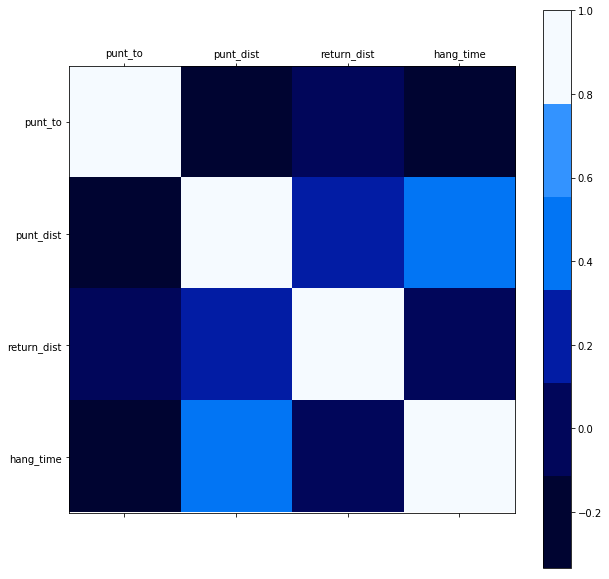

In [245]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)

plt.matshow(corr_df.corr(), cmap=cmap)
plt.xticks(range(len(corr_df.columns)), corr_df.columns)
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar()
plt.show()

In [108]:
pdd.groupby('punt_to_bin', as_index=False)['return_dist'].mean()

,punt_to_bin,return_dist
0,"(0, 10]",3.217006
1,"(10, 20]",4.622761
2,"(20, 30]",5.839453
3,"(30, 40]",5.453855
4,"(40, 50]",4.451613


In [106]:
inside_ten.head()

,Season_Year,GameKey,PlayID,PlayDescription,outcome,punt_to,punt_dist,return_dist,hang_time,punt_dist_bin,punt_to_bin,hang_time_bin
0,2016,4,291,"(9:32) T.Masthay punts 38 yards to CLV 9, Center-R.Lovato, fair catch by T.Williams. PENALTY on CLV-J.Schobert, Running Into the Kicker, 5 yards, enforced at CLV 47 - No Play.",fair_catch,9,38,0,4.2,"(35, 40]","(0, 10]","(4.0, 4.5]"
1,2016,4,2795,"(5:00) A.Lee punts 49 yards to GB 1, Center-C.Hughlett, downed by CLV-R.Louis.",downed,1,49,0,NaN,"(45, 50]","(0, 10]",NaN
2,2016,4,3900,"(2:26) P.Mortell punts 37 yards to CLV 4, Center-R.Lovato, out of bounds.",oob,4,37,0,NaN,"(35, 40]","(0, 10]",NaN
3,2016,5,3864,"(6:39) (Punt formation) B.Colquitt punts 37 yards to CHI 8, Center-C.Kreiter, out of bounds.",oob,8,37,0,NaN,"(35, 40]","(0, 10]",NaN
4,2016,6,852,"(1:07) (Punt formation) S.Martin punts 47 yards to PIT 9, Center-D.Muhlbach, fair catch by E.Rogers.",fair_catch,9,47,0,5.2,"(45, 50]","(0, 10]","(5.0, 5.5]"
